In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

device = torch.device("mps")

### Create Dataset

In [20]:
u0=np.array([2.5,0]).T
u1=np.array([-2.5,0]).T

covar0=[[1,0],[0,1]]
covar1=[[1,0],[0,1]]

XP = np.random.multivariate_normal(u0,covar0,750)
XN = np.random.multivariate_normal(u1,covar1,750)
YP = np.ones(750)
YN = np.zeros(750)
# YN.fill(-1)
X , Y = np.concatenate((XP,XN)),np.hstack((YP,YN))
X, Y = shuffle(X,Y,random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=250, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=250, random_state=1)

### SVM

In [21]:
class SVM():
    def __init__(self, c=0.01, lr=0.1, batchsize=5, epoch=10):
        self.c = c
        self.lr = lr
        self.batchsize = batchsize
        self.epoch = epoch
        self.model = nn.Linear(2, 1)
        self.model.to(device)

    def train(self, X, Y, X_val, y_val):

        X = torch.FloatTensor(X)
        Y = 2*Y-1
        y_val = 2*y_val-1
        Y = torch.FloatTensor(Y)
        N = len(Y)

        optimizer = optim.SGD(self.model.parameters(), lr=self.lr)

        self.model.train()
        for ep in range(self.epoch):
            permute = torch.randperm(N)
            sum_loss = 0

            for i in range(0, N, self.batchsize):
                x = X[permute[i : i + self.batchsize]].to(device)
                y = Y[permute[i : i + self.batchsize]].to(device)

                optimizer.zero_grad()
                output = self.model(x).squeeze()
                weight = self.model.weight.squeeze()

                loss = torch.mean(torch.clamp(1 - y * output, min=0))
                loss += self.c * (weight.t() @ weight) / 2.0

                loss.backward()
                optimizer.step()

                sum_loss += float(loss)
            
            print("Epoch: {:4d}\tTraining loss: {}".format(ep+1, sum_loss / N))
            print("Validation accuracy: ",accuracy_score(y_val,self.predict(X_val)))

    def predict(self, X):
        W = self.model.weight.squeeze().detach().cpu().numpy()
        b = self.model.bias.squeeze().detach().cpu().numpy()
        y_test_predicted = np.array([])
        for i in range(X.shape[0]):
            yp = np.sign(np.dot(W, X[i])+b) #model
            y_test_predicted = np.append(y_test_predicted, yp)
        return y_test_predicted

In [38]:
svmbase = SVM()
svmbase.train(X_train, y_train, X_val, y_val)

score = accuracy_score(2*y_test-1,svmbase.predict(X_test))
print(f"Test Accuracy: {score}")

Epoch:    1	Training loss: 0.009576049585826694
Validation accuracy:  1.0
Epoch:    2	Training loss: 0.00594445314630866
Validation accuracy:  1.0
Epoch:    3	Training loss: 0.005981615304015577
Validation accuracy:  1.0
Epoch:    4	Training loss: 0.005941812137141823
Validation accuracy:  1.0
Epoch:    5	Training loss: 0.005957811034284532
Validation accuracy:  1.0
Epoch:    6	Training loss: 0.00590845569036901
Validation accuracy:  1.0
Epoch:    7	Training loss: 0.0059549440024420615
Validation accuracy:  1.0
Epoch:    8	Training loss: 0.005926717123016715
Validation accuracy:  1.0
Epoch:    9	Training loss: 0.005969324826262891
Validation accuracy:  1.0
Epoch:   10	Training loss: 0.005932010034099221
Validation accuracy:  1.0
Test Accuracy: 0.996


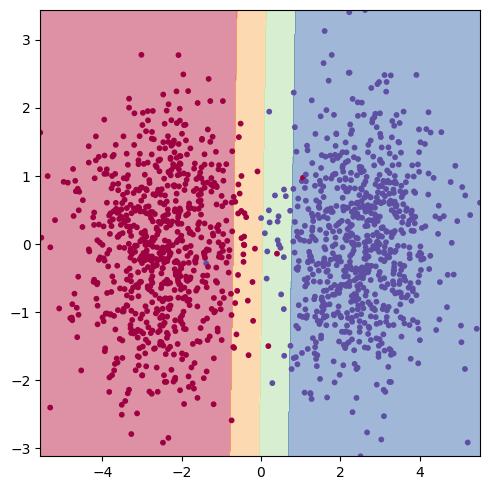

In [39]:
W = svmbase.model.weight.squeeze().detach().cpu().numpy()
b = svmbase.model.bias.squeeze().detach().cpu().numpy()

n = 4000
x = np.linspace(X[:, 0].min(), X[:, 0].max(), n)
y = np.linspace(X[:, 1].min(), X[:, 1].max(), n)
x, y = np.meshgrid(x, y)
xy = list(map(np.ravel, [x, y]))

z = (W.dot(xy) + b).reshape(x.shape)
z[np.where(z > 1.0)] = 4
z[np.where((z > 0.0) & (z <= 1.0))] = 3
z[np.where((z > -1.0) & (z <= 0.0))] = 2
z[np.where(z <= -1.0)] = 1

plt.figure(figsize=(5, 5))
plt.contourf(x, y, z, alpha=0.5, cmap='Spectral')
plt.scatter(x=X[:, 0], y=X[:, 1], c=Y, s=10, cmap='Spectral')
plt.tight_layout()
plt.show()

### Logistic Regression

In [22]:

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

class LogReg():
    def __init__(self, epoch=200, input_dim=2, output_dim=1, lr=0.1):
        self.epochs = epoch
        self.input_dim = input_dim # Two inputs x1 and x2 
        self.output_dim = output_dim # Two possible outputs
        self.lr = lr
        self.model = LogisticRegression(input_dim,output_dim).to(device)

    def train(self, X_train, y_train, X_val, y_val):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr)
        X_train, y_train = torch.Tensor(X_train).to(device), torch.Tensor(y_train).to(device)
        X_val = torch.Tensor(X_val).to(device)

        self.model.train()
        for epoch in range(self.epochs):
            optimizer.zero_grad()

            outputs = self.model(X_train)
            loss = criterion(torch.squeeze(outputs), y_train)
            
            loss.backward()
            
            optimizer.step()
            
            if (epoch+1)%20==0 or epoch==0:
                # calculate Accuracy
                with torch.no_grad():
                    # Calculating the loss and accuracy for the val dataset
                    outputs_test = torch.squeeze(self.model(X_val))
                    predicted_test = outputs_test.round().detach().cpu().numpy()
                    predicted_test = np.asarray(predicted_test>=0.5,dtype=np.int64)
                    val_acc = accuracy_score(y_val,predicted_test)
                    
                    # Calculating the loss and accuracy for the train dataset
                    y_hat_train = torch.squeeze(self.model(X_train))
                    y_hat_train = y_hat_train.detach().cpu().numpy()
                    y_hat_train = np.asarray(y_hat_train>=0.5,dtype=np.int64)
                    train_acc = accuracy_score(y_train.detach().cpu().numpy(), y_hat_train)
                    
                    print(f"Iteration: {epoch+1}. \nValidation - Accuracy: {val_acc}")
                    print(f"Train -  Loss: {loss.item()}. Accuracy: {train_acc}\n")

    def predict(self, X):
        X = torch.Tensor(X).to(device)
        with torch.no_grad():
            outputs_test = torch.squeeze(self.model(X))
            predicted_test = outputs_test.round().detach().cpu().numpy()
            predicted_test = np.asarray(predicted_test>=0.5,dtype=np.int64)
        return predicted_test

In [45]:
logregbase = LogReg()
logregbase.train(X_train, y_train, X_val, y_val)
score = accuracy_score(y_test,logregbase.predict(X_test))
print(f"Test Accuracy: {score}")

Iteration: 1. 
Validation - Accuracy: 0.88
Train -  Loss: 0.69831383228302. Accuracy: 0.85

Iteration: 20. 
Validation - Accuracy: 1.0
Train -  Loss: 0.13728931546211243. Accuracy: 0.995

Iteration: 40. 
Validation - Accuracy: 1.0
Train -  Loss: 0.0880194678902626. Accuracy: 0.997

Iteration: 60. 
Validation - Accuracy: 1.0
Train -  Loss: 0.069184310734272. Accuracy: 0.996

Iteration: 80. 
Validation - Accuracy: 1.0
Train -  Loss: 0.05894207954406738. Accuracy: 0.996

Iteration: 100. 
Validation - Accuracy: 1.0
Train -  Loss: 0.052404969930648804. Accuracy: 0.996

Iteration: 120. 
Validation - Accuracy: 1.0
Train -  Loss: 0.04782780632376671. Accuracy: 0.996

Iteration: 140. 
Validation - Accuracy: 1.0
Train -  Loss: 0.04442295432090759. Accuracy: 0.996

Iteration: 160. 
Validation - Accuracy: 1.0
Train -  Loss: 0.04177957400679588. Accuracy: 0.996

Iteration: 180. 
Validation - Accuracy: 1.0
Train -  Loss: 0.03966110572218895. Accuracy: 0.996

Iteration: 200. 
Validation - Accuracy: 1

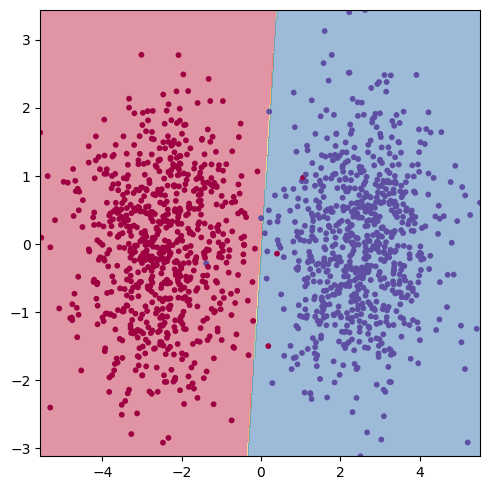

In [44]:
n = 400
x = np.linspace(X[:, 0].min(), X[:, 0].max(), n)
y = np.linspace(X[:, 1].min(), X[:, 1].max(), n)
x, y = np.meshgrid(x, y)
xy = np.array(list(map(np.ravel, [x, y]))).T

z = logregbase.predict(xy).reshape(x.shape)

plt.figure(figsize=(5, 5))
plt.contourf(x, y, z, alpha=0.5, cmap='Spectral')
plt.scatter(x=X[:, 0], y=X[:, 1], c=Y, s=10, cmap='Spectral')
plt.tight_layout()
plt.show()

### KNN

In [60]:
for i in range(1, 20):
    knn = KNeighborsRegressor(n_neighbors=i, weights='distance')
    knn.fit(X_train, y_train)
    pred_i = np.round(knn.predict(X_val),decimals=0)
    mae = accuracy_score(y_val, pred_i)
    print(f'Accuracy for K={i} is {round(mae,5)}')

Accuracy for K=1 is 0.992
Accuracy for K=2 is 0.992
Accuracy for K=3 is 1.0
Accuracy for K=4 is 1.0
Accuracy for K=5 is 1.0
Accuracy for K=6 is 1.0
Accuracy for K=7 is 1.0
Accuracy for K=8 is 1.0
Accuracy for K=9 is 1.0
Accuracy for K=10 is 1.0
Accuracy for K=11 is 1.0
Accuracy for K=12 is 1.0
Accuracy for K=13 is 1.0
Accuracy for K=14 is 1.0
Accuracy for K=15 is 1.0
Accuracy for K=16 is 1.0
Accuracy for K=17 is 1.0
Accuracy for K=18 is 1.0
Accuracy for K=19 is 1.0


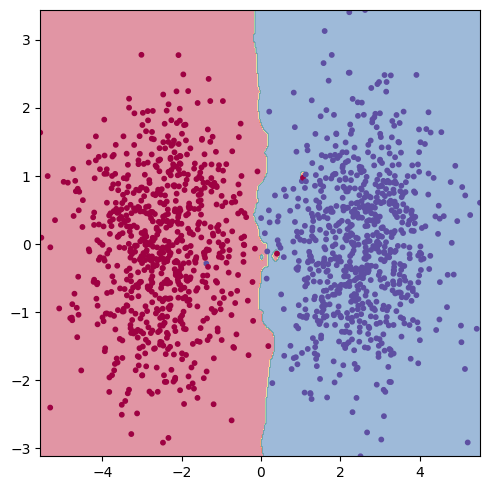

In [62]:
knn = KNeighborsRegressor(n_neighbors=3, weights='distance')
knn.fit(X_train, y_train)
n = 400
x = np.linspace(X[:, 0].min(), X[:, 0].max(), n)
y = np.linspace(X[:, 1].min(), X[:, 1].max(), n)
x, y = np.meshgrid(x, y)
xy = np.array(list(map(np.ravel, [x, y]))).T

z = np.round(knn.predict(xy),decimals=0).reshape(x.shape)

plt.figure(figsize=(5, 5))
plt.contourf(x, y, z, alpha=0.5, cmap='Spectral')
plt.scatter(x=X[:, 0], y=X[:, 1], c=Y, s=10, cmap='Spectral')
plt.tight_layout()
plt.show()

### Naive Bias

In [14]:
nb = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb, 
            param_grid=params_NB, 
            cv=10,   # use any cross validation technique 
            verbose=1, 
            scoring='accuracy') 
gs_NB.fit(X_train, y_train)
print(gs_NB.best_params_)
best_pred = gs_NB.predict(X_test)
acc = accuracy_score(y_test,best_pred)
print("Test accuracy: ",acc)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'var_smoothing': 1.0}
Test accuracy:  0.992


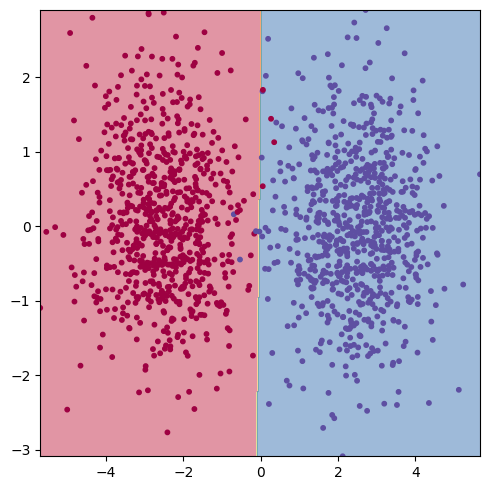

In [15]:
n = 400
x = np.linspace(X[:, 0].min(), X[:, 0].max(), n)
y = np.linspace(X[:, 1].min(), X[:, 1].max(), n)
x, y = np.meshgrid(x, y)
xy = np.array(list(map(np.ravel, [x, y]))).T

z = gs_NB.predict(xy).reshape(x.shape)

plt.figure(figsize=(5, 5))
plt.contourf(x, y, z, alpha=0.5, cmap='Spectral')
plt.scatter(x=X[:, 0], y=X[:, 1], c=Y, s=10, cmap='Spectral')
plt.tight_layout()
plt.show()

In [24]:
scores_svm = []
scores_log = []
scores_knn = []
scores_nb = []
for u in np.linspace(1.0,2.4,8):

    u0=np.array([u,0]).T
    u1=np.array([-u,0]).T

    covar0=[[1,0],[0,1]]
    covar1=[[1,0],[0,1]]

    XP = np.random.multivariate_normal(u0,covar0,750)
    XN = np.random.multivariate_normal(u1,covar1,750)
    YP = np.ones(750)
    YN = np.zeros(750)
    # YN.fill(-1)
    X , Y = np.concatenate((XP,XN)),np.hstack((YP,YN))
    X, Y = shuffle(X,Y,random_state=1)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=250, random_state=2)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=250, random_state=1)
    
    svm = SVM()
    svm.train(X_train, y_train, X_val, y_val)
    score_svm = accuracy_score(2*y_test-1, svm.predict(X_test))
    scores_svm.append(score_svm)

    logreg = LogReg()
    logreg.train(X_train, y_train, X_val, y_val)
    score_log = accuracy_score(y_test, logreg.predict(X_test))
    scores_log.append(score_log)

    knn = KNeighborsRegressor(n_neighbors=3, weights='distance')
    knn.fit(X_train, y_train)
    score_knn = accuracy_score(y_test, np.round(knn.predict(X_test),0))
    scores_knn.append(score_knn)

    nb = GaussianNB(var_smoothing=1)
    nb.fit(X_train, y_train)
    score_nb = accuracy_score(y_test, nb.predict(X_test))
    scores_nb.append(score_nb)

Epoch:    1	Training loss: 0.07958214916754514
Validation accuracy:  0.848
Epoch:    2	Training loss: 0.07519676158484072
Validation accuracy:  0.844
Epoch:    3	Training loss: 0.07491451346315443
Validation accuracy:  0.84
Epoch:    4	Training loss: 0.07499932215176523
Validation accuracy:  0.848
Epoch:    5	Training loss: 0.07489987649396061
Validation accuracy:  0.844
Epoch:    6	Training loss: 0.07479343293374405
Validation accuracy:  0.848
Epoch:    7	Training loss: 0.0751677271341905
Validation accuracy:  0.832
Epoch:    8	Training loss: 0.07493799884244799
Validation accuracy:  0.84
Epoch:    9	Training loss: 0.07464925603847951
Validation accuracy:  0.844
Epoch:   10	Training loss: 0.0749528810218908
Validation accuracy:  0.84
Iteration: 1. 
Validation - Accuracy: 0.256
Train -  Loss: 1.1178205013275146. Accuracy: 0.279

Iteration: 20. 
Validation - Accuracy: 0.764
Train -  Loss: 0.5505774021148682. Accuracy: 0.768

Iteration: 40. 
Validation - Accuracy: 0.832
Train -  Loss: 0.

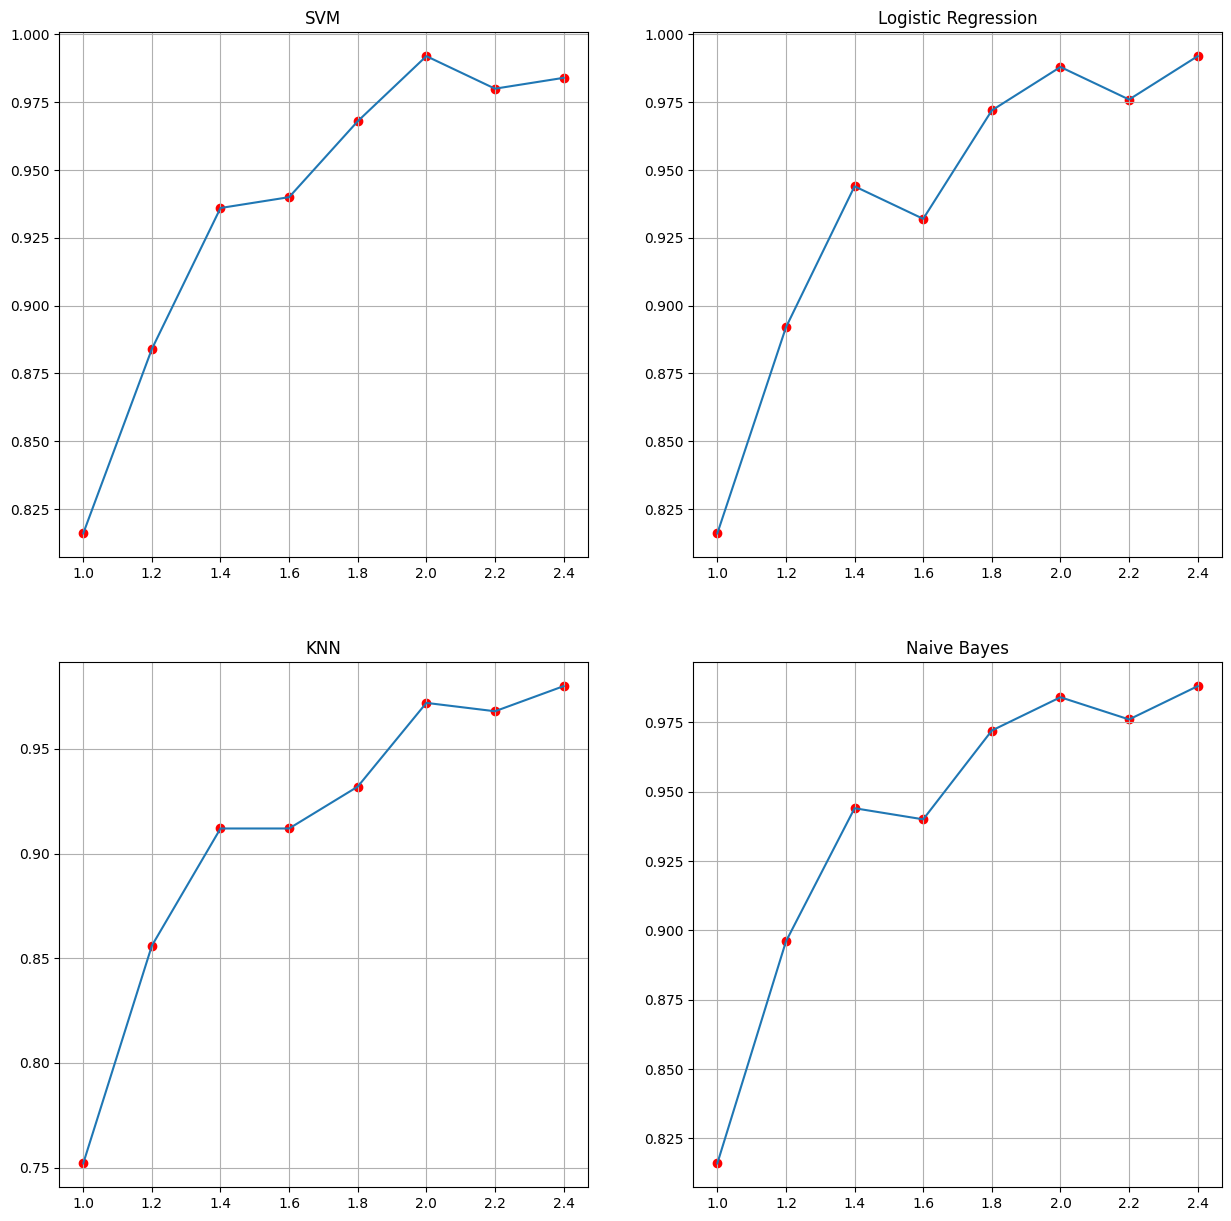

In [31]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(221)
ax.plot(np.linspace(1.0,2.4,8),scores_svm)
ax.scatter(np.linspace(1.0,2.4,8),scores_svm,c='red')
ax.title.set_text(f"SVM")
ax.grid(True)

ax = fig.add_subplot(222)
ax.plot(np.linspace(1.0,2.4,8),scores_log)
ax.scatter(np.linspace(1.0,2.4,8),scores_log,c='red')
ax.title.set_text(f"Logistic Regression")
ax.grid(True)

ax = fig.add_subplot(223)
ax.plot(np.linspace(1.0,2.4,8),scores_knn)
ax.scatter(np.linspace(1.0,2.4,8),scores_knn,c='red')
ax.title.set_text(f"KNN")
ax.grid(True)

ax = fig.add_subplot(224)
ax.plot(np.linspace(1.0,2.4,8),scores_nb)
ax.scatter(np.linspace(1.0,2.4,8),scores_nb,c='red')
ax.title.set_text(f"Naive Bayes")
ax.grid(True)

plt.show()